In [3]:
using StatsBase
using Plots

In [4]:
function initialstate(L::Int)
    ρ = zeros(Bool,L,L)
    return ρ
end

function noiselayer(ρ::AbstractMatrix, p::Float64)
    L = size(ρ)[1]
    noise = rand(L,L) .< p
    return ρ .⊻ noise
end

function magnetization(ρ::AbstractMatrix)
    return mean(ρ)
end

magnetization (generic function with 1 method)

In [5]:
function measure(ρ::AbstractMatrix, q::Float64)
    vertical_checks = noiselayer(ρ .⊻ circshift(ρ,(-1,0)),q)
    horizontal_checks = noiselayer(ρ .⊻ circshift(ρ,(0,-1)),q)
    return vertical_checks, horizontal_checks
end

function toom(ρ::AbstractMatrix, checks::Tuple)
    vertical_checks, horizontal_checks = checks
    ρ = ρ .⊻ (vertical_checks .& horizontal_checks)
    return ρ
end

toom (generic function with 1 method)

In [91]:
function PL(ρ::AbstractMatrix, checks::Tuple, pstar::Float64, q::Float64, depth::Int)
    correction = mcmc(checks, pstar, q, depth)
    return ρ .⊻ correction
end

function mcmc(checks::Tuple, pstar::Float64, q::Float64, depth::Int)
    vertical_checks, horizontal_checks = checks
    L = size(vertical_checks)[1]
    spins = zeros(Bool, L, L)
    J = -0.5*log(q/(1-q))
    h = -0.5*log(pstar/(1-pstar))
    for _ in 1:depth
        x = rand(1:L)
        y = rand(1:L)
        vertical_dws, horizontal_dws = measure(spins, 0.0)
        vertical_dws = vertical_dws .⊻ vertical_checks
        horizontal_dws = horizontal_dws .⊻ horizontal_checks
        disagreements = vertical_dws[mod1(y-1,L),x] + vertical_dws[y,x] + horizontal_dws[y,mod1(x-1,L)] + horizontal_dws[y,x]
        
        ΔE = -4J*(disagreements - 2) + 2h*(1-2spins[y,x])        
        
        if ΔE <= 0
            spins[y,x] = spins[y,x] ⊻ true
        else
            if rand() < exp(-ΔE)
                spins[y,x] = spins[y,x] ⊻ true
            end
        end
    end
    return spins
end
    
function mcmc_with_history(checks::Tuple, pstar::Float64, q::Float64, depth::Int)
    vertical_checks, horizontal_checks = checks
    L = size(vertical_checks)[1]
    spinses = zeros(Bool, depth, L, L)
    J = -0.5*log(q/(1-q))
    h = -0.5*log(pstar/(1-pstar))
    for t in 1:depth-1
        x = rand(1:L)
        y = rand(1:L)
        vertical_dws, horizontal_dws = measure(spinses[t,:,:], 0.0)
        vertical_dws = vertical_dws .⊻ vertical_checks
        horizontal_dws = horizontal_dws .⊻ horizontal_checks
        disagreements = vertical_dws[mod1(y-1,L),x] + vertical_dws[y,x] + horizontal_dws[y,mod1(x-1,L)] + horizontal_dws[y,x]
        ΔE = -4J*(disagreements - 2) + 2h*(1-2spinses[t,y,x])

        # if x==y==3
        #             println(disagreements)
        #             println(2h*(1-2spinses[t,y,x]))
        # end
        
        spinses[t+1,:,:] = spinses[t,:,:]
        if ΔE <= 0
            spinses[t+1,y,x] = spinses[t,y,x] ⊻ true
        else
            if rand() < exp(-ΔE)
                spinses[t+1,y,x] = spinses[t,y,x] ⊻ true
            end
        end
    end
    return spinses
end

mcmc_with_history (generic function with 1 method)

In [92]:
# L = 4
# spins = zeros(Bool, L, L)
# vertical_checks, horizontal_checks = measure(spins, 0.0)
# spinses = mcmc_with_history((vertical_checks, horizontal_checks), 0.5, 0.4, 1000)
# [magnetization(spinses[t,:,:]) for t in 1:1000]

In [103]:
spins = [0 0 0 0
         0 0 1 0
         0 0 1 0 
         0 0 0 0]

pstar = 0.1
q = 0.1
vertical_checks, horizontal_checks = measure(spins,q)

depth = 100
spinses = mcmc_with_history(measure(spins,q), pstar, q, depth);

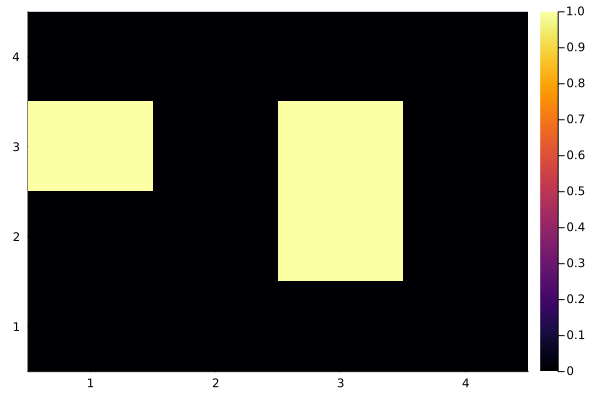

In [104]:
heatmap(spinses[end,:,:])

In [48]:
L = 4
J = -0.5*log(q/(1-q))
h = -0.5*log(pstar/(1-pstar))
x = 3
y = 3

spins = zeros(Bool,L,L)

vertical_dws, horizontal_dws = measure(spins, 0.0)
vertical_dws = vertical_dws .⊻ vertical_checks
horizontal_dws = horizontal_dws .⊻ horizontal_checks
disagreements = vertical_dws[mod1(y-1,L),x] + vertical_dws[y,x] + horizontal_dws[y,mod1(x-1,L)] + horizontal_dws[y,x]
# ΔE = -4J*(disagreements - 2) + 2h*(1-2spins[y,x])

3

In [47]:
vertical_checks

4×4 Matrix{Int64}:
 0  0  1  0
 0  0  0  0
 0  0  1  0
 0  0  0  0

In [42]:
d == horizontal_checks

true

In [152]:
J

Inf

In [89]:
L = 20
T = 10000
p = 0.05
q = 0.05
ρs = zeros(Bool,T,L,L)
ρs[1,:,:] = initialstate(L)

for t in 2:T
    ρnew = noiselayer(ρs[t-1,:,:], p)
    ρs[t,:,:] = toom(ρnew, measure(ρnew, q))
end

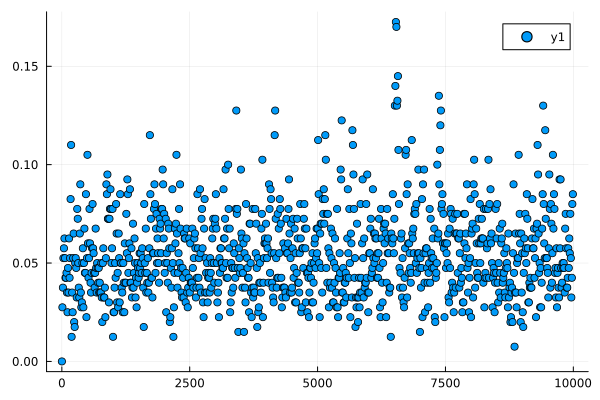

In [90]:
ys = [magnetization(ρs[t,:,:]) for t in 1:T]
plot(1:10:T,ys[1:10:end], seriestype=:scatter)

In [178]:
mags = Dict{Tuple{Int,Float64,Float64,Float64},Vector}()
# mags2 = deepcopy(mags)

Dict{Tuple{Int64, Float64, Float64, Float64}, Vector}()

In [189]:
L = 10
T = 100L
p = 0.1
q = 0.1
pstar = 0.01
samples = 1

ms = zeros(2T)

# maybe double depth and alternate between noise and correction

for _ in 1:samples
    ρs = zeros(Bool,2T,L,L)
    ρs[1,:,:] = initialstate(L)
    ρs[2,:,:] = initialstate(L)


    depth = 10L^2

    for t in 2:T
        ρnew = noiselayer(ρs[2t-2,:,:], p)
        ρs[2t-1,:,:] = ρnew
        ρs[2t,:,:] = PL(ρnew, measure(ρnew, q), pstar, q, depth)
    end

    ys = [magnetization(ρs[t,:,:]) for t in 1:2T]
    ms += ys
end
mags[(L,p,q,pstar)] = ms/samples;

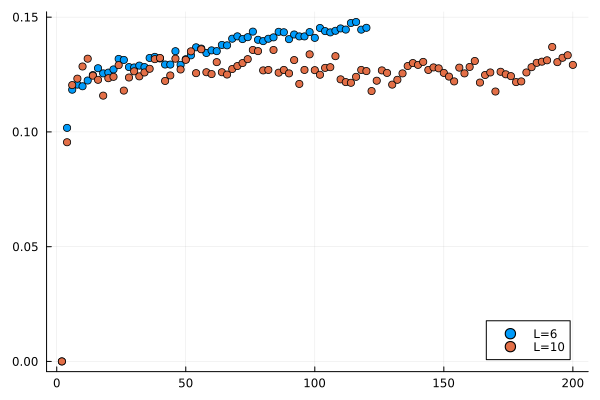

In [203]:
# ys = [magnetization(ρs[t,:,:]) for t in 1:T]
p = 0.1
q = 0.1
pstar = 0.1

plt = plot()
for L in [6,10]
    T = 10L
    xs = collect(2:2:2T)
    ys = mags2[(L,p,q,pstar)][1:2:2T]
    plot!(xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [211]:
L = 6
T = 1000L
p = 0.1
q = 0.1
pstar = 0.1
samples = 100

ms = zeros(2T)

# maybe double depth and alternate between noise and correction

for _ in 1:samples
    ρs = zeros(Bool,2T,L,L)
    ρs[1,:,:] = initialstate(L)
    ρs[2,:,:] = initialstate(L)


    depth = 10L^2

    for t in 2:T
        ρnew = noiselayer(ρs[2t-2,:,:], p)
        ρs[2t-1,:,:] = ρnew
        ρs[2t,:,:] = PL(ρnew, measure(ρnew, q), pstar, q, depth)
    end

    ys = [magnetization(ρs[t,:,:]) for t in 1:2T]
    ms += ys
end
mags2[(L,p,q,pstar)] = ms/samples;

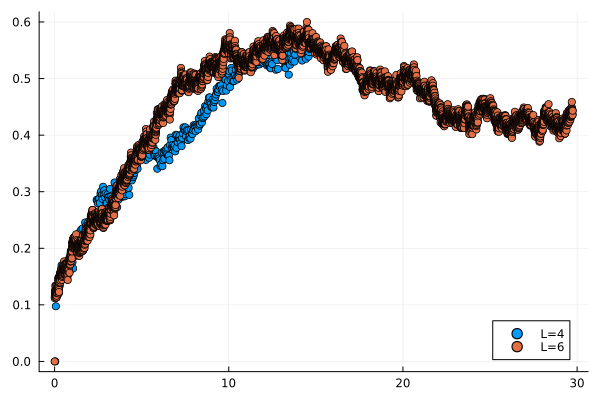

In [217]:
# ys = [magnetization(ρs[t,:,:]) for t in 1:T]
p = 0.1
q = 0.1
pstar = 0.1

plt = plot()
for L in [4,6]
    T = L == 4 ? 100L : 1000L
    xs = collect(2:2:2T)/exp(L)
    ys = mags2[(L,p,q,pstar)][1:2:2T]
    plot!(xs, ys, seriestype=:scatter, label="L=$L")
end
plt